In [47]:
import envs.frame_generator as frame_generator
import envs.constant_frame_generator as constant_frame_generator
import envs.random_frame_generator as random_frame_generator
from utils.layer_output_calculator import LayerOutputCalculator
from sb3model_wrappers.recurrentppo_wrapper import sb3Wrapper
from utils.neural_importance import get_extreme_weight_neurons, get_topn_neurons_per_action
from utils.neural_oscillations import plot_hidden_state, fft, pca

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import torch as t

In [3]:
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
TRAIN_VIDEO_PATH = "videos/V1-0001_City Scene Layout 1 setting0001.mp4"
VIDEO_FPS = 24
FRAME_SIZE = (124,124)
N_EPISODES = 50000

In [23]:
env = frame_generator.FrameGenerator(TRAIN_VIDEO_PATH, TRAIN_VIDEO_PATH,VIDEO_FPS, FRAME_SIZE, n_episodes=N_EPISODES)
env_constant = constant_frame_generator.ConstantFrameGenerator(TRAIN_VIDEO_PATH, TRAIN_VIDEO_PATH,VIDEO_FPS, FRAME_SIZE, n_episodes=N_EPISODES)
env_random = random_frame_generator.RandomFrameGenerator(TRAIN_VIDEO_PATH, TRAIN_VIDEO_PATH,VIDEO_FPS, FRAME_SIZE, n_episodes=N_EPISODES)

In [27]:
env_test = env_random

_, obs = env_test.reset()

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))  # Create two subplots

# Initialize images for both subplots
image_axes_1 = ax1.imshow(env_test.video_frames[0], cmap='viridis')


plt.close()  # Prevent duplicate static display in Jupyter Notebook

# Function to update both images
def update_mask(j):
    image_axes_1.set_array(env_test.video_frames[j])
    return [image_axes_1]

# Create the animation
animated_hands = FuncAnimation(fig, update_mask, frames=range(len(env_test.video_frames)), blit=True)

# Display the animation
HTML(animated_hands.to_jshtml())


# test env step

In [46]:

env_test = env_random 
model = RecurrentPPO.load('models/sb3_ppo_1goal_rnn_multistop_multiseq', env=env_test)

obs, _ = env_test.reset()

states = None
print("target time",env_test.target_duration)
for _ in range(60):
    action, states = model.predict(obs, state=states , deterministic=True)
    print("action",action)

    obs, reward, done, _ ,_= env_test.step(action)
    # print("reward",reward)
    print("current_frame_index",env_test.current_frame_index)

    if done:
        obs,_ = env_test.reset()
        print("reward",reward)
        break

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
target time 4
action 0
current_frame_index 1
action 0
current_frame_index 2
action 0
current_frame_index 3
action 1
current_frame_index 4
action 0
current_frame_index 5
action 0
current_frame_index 6
action 0
current_frame_index 7
action 1
current_frame_index 8
action 0
current_frame_index 9
action 0
current_frame_index 10
action 0
current_frame_index 11
action 1
current_frame_index 12
action 0
current_frame_index 13
action 0
current_frame_index 14
action 0
current_frame_index 15
action 1
current_frame_index 16
action 0
current_frame_index 17
action 0
current_frame_index 18
action 0
current_frame_index 19
action 1
current_frame_index 20
reward 1


# neural oscillations

In [4]:

def get_info_for_neural_oscillation(wrapped_model_durt, model_durt, env_durt,
                                    video_path="videos/V1-0001_City Scene Layout 1 setting0001.mp4", model_path = 'models/sb3_ppo_1goal_rnn_multistop_multiseq', 
                                    video_fps=24, frame_size=(124,124), target_duration=4, process_layer_output=True, threshold=2 ):
    
    if process_layer_output:

        
        targett_output_calculator = LayerOutputCalculator(wrapped_model_durt, model_durt, env_durt)
        targett_output_calculator.get_layer_outputs_per_episode()

        action_weights = model_durt.policy.state_dict()["action_net.weight"]
        high_z_indices, low_z_indices = get_extreme_weight_neurons(action_weights,threshold)
        topn_action_weights = get_topn_neurons_per_action(action_weights)

    else:
        targett_output_calculator = None
        action_weights = model_durt.policy.state_dict()["action_net.weight"]
        high_z_indices, low_z_indices = get_extreme_weight_neurons(action_weights,threshold)
        topn_action_weights = get_topn_neurons_per_action(action_weights)

    return targett_output_calculator, high_z_indices, low_z_indices, topn_action_weights

In [92]:
def plot_hidden_state(lstm_hidden, lstm_cell, high_z_indices, low_z_indices, top_neurons_a0, save_path=None):
    hidden_states_list = [h_t.flatten() for h_t in lstm_hidden]
    cell_states_list = [c_t.flatten() for c_t in lstm_cell]

    hidden_states_array = np.array(hidden_states_list)[:, :]
    cell_states_array = np.array(cell_states_list)[:, :]

    # filter for action 1 neurons
    high_z_indices = [i for i in high_z_indices if i not in top_neurons_a0]

    hidden_states_array_least_weight_neurons = np.array(hidden_states_list)[:, low_z_indices]  # remove 173
    # cell_states_array_least_weight_neurons = np.array(cell_states_list)[:,[8,205,125]]

    hidden_states_array_top_neurons = np.array(hidden_states_list)[:, high_z_indices]  # remove 39
    plt.figure(figsize=(14, 4))

    # Hidden state
    line_all = plt.plot(hidden_states_array, marker="o", alpha=0.2, linestyle="--", label="All neurons")
    line_least = plt.plot(hidden_states_array_least_weight_neurons, marker="o", color="red", linestyle="-",
                          label="Least weighted neurons")
    line_top = plt.plot(hidden_states_array_top_neurons, marker="o", color="blue", linestyle="-",
                        label="High weighted neurons")
    # plt.legend(handles=[line_all[0], line_least, line_top[0]])
    # plt.title("LSTM Hidden State Evolution Over Time")
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Hidden State Value", fontsize=12)


    plt.xticks(range(0, len(hidden_states_list)), fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [91]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca(squeezed_policy_layer, pca_components=3, total_timestep=20, save_path=None):
    scaler_policy = StandardScaler()

    policy_layer_scaled = scaler_policy.fit_transform(squeezed_policy_layer)

    pca_policy = PCA(n_components=pca_components)

    policy_layer_pc = pca_policy.fit_transform(policy_layer_scaled)

    explained_variance_policy = pca_policy.explained_variance_ratio_

    print("explained_variance policy", explained_variance_policy)

    colors = ['royalblue', 'deepskyblue', 'goldenrod']
    plt.figure(figsize=(8, 4))
    for i in range(policy_layer_pc.shape[1]):
        plt.plot(policy_layer_pc[:, i], marker='o', label=f'PC {i + 1} ({round(explained_variance_policy[i]*100)}%)', alpha=0.8, color=colors[i])

    # plt.title("Principal component analysis (PCA) of LSTM Hidden States Over Time", fontsize=14)
    plt.xlabel("Time Step", fontsize=12)
    # plt.ylabel("Principal Component Value", fontsize=12)
    plt.xticks(range(policy_layer_pc.shape[0]))
    plt.legend(loc='lower right', frameon=True, fontsize=10)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    return policy_layer_pc


def fft(squeezed_policy_layer, high_z_indices, low_z_indices, save_path=None):
    # N - number of neurons
    # T - time steps
    squeezed_policy_layer_NT = squeezed_policy_layer.T  # Shape: (N, T)

    # Apply FFT to each neuron's time series
    fft_policy_results = np.fft.rfft(squeezed_policy_layer_NT, axis=1)
    fft_policy_magnitudes = np.abs(fft_policy_results)

    # Compute frequency bins
    time_steps = squeezed_policy_layer.shape[0]
    sampling_rate = 1  # 1 sample per timestep;
    freqs = np.fft.rfftfreq(time_steps, d=1 / sampling_rate)

    plt.figure(figsize=(8, 3))

    for i in range(squeezed_policy_layer.shape[1]):
        if i in high_z_indices:
            plt.plot(freqs[:time_steps ], fft_policy_magnitudes[i, :time_steps // 1], color="blue", marker="o")
        elif i in low_z_indices:
            plt.plot(freqs[:time_steps // 1], fft_policy_magnitudes[i, :time_steps // 1], color="red", marker="o")
        else:
            plt.plot(freqs[:time_steps // 1], fft_policy_magnitudes[i, :time_steps // 1], marker="o", alpha=0.05,
                     color="lightgrey", linestyle="--")

        # break

    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Magnitude", fontsize=12)
    plt.xticks(np.arange(0, 0.55, 0.05))
    plt.tight_layout()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


# duration = 4

In [88]:

video_path="videos/V1-0001_City Scene Layout 1 setting0001.mp4"
model_path = 'models/sb3_ppo_1goal_rnn_multistop_multiseq'
target_duration = 4

env_durt = frame_generator.FrameGenerator(video_path, video_path, 24, (124,124),
                                     n_episodes=10, target_duration=target_duration)
model_durt = RecurrentPPO.load(model_path, env=env_durt)


wrapped_model_durt = sb3Wrapper(model_durt)

target4_output_calculator, high_z_indices_dur4, low_z_indices_dur4, topn_action_weights_dur4 = get_info_for_neural_oscillation(wrapped_model_durt, model_durt, env_durt, video_path=video_path, model_path=model_path, target_duration=target_duration)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
target time 4
current_frame_index 0
action 0
reward 0
current_frame_index 1
action 0
reward 0
current_frame_index 2
action 0
reward 0
current_frame_index 3
action 1
reward 1
current_frame_index 4
action 0
reward 0
current_frame_index 5
action 0
reward 0
current_frame_index 6
action 0
reward 0
current_frame_index 7
action 1
reward 1
current_frame_index 8
action 0
reward 0
current_frame_index 9
action 0
reward 0
current_frame_index 10
action 0
reward 0
current_frame_index 11
action 1
reward 1
current_frame_index 12
action 1
reward -1
current_frame_index 13
action 0
reward 0
current_frame_index 14
action 0
reward 0
current_frame_index 15
action 1
reward 1
current_frame_index 16
action 0
reward 0
current_frame_index 17
action 0
reward 0
current_frame_index 18
action 0
reward 0
current_frame_index 19
action 1
reward 1
total rewards 4


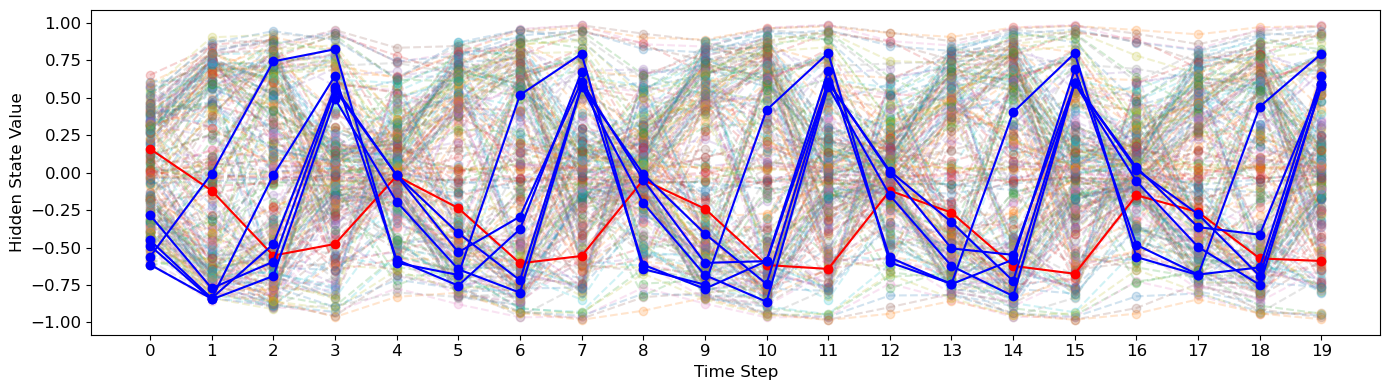

In [13]:
plot_hidden_state(target4_output_calculator.lstm_hidden, target4_output_calculator.lstm_cell, high_z_indices_dur4, low_z_indices_dur4, topn_action_weights_dur4[0])

In [89]:
squeezed_lstm_policy = np.array(target4_output_calculator.lstm_hidden).squeeze(1).squeeze(1)
squeezed_lstm_value = np.array(target4_output_calculator.lstm_cell).squeeze(1).squeeze(1)

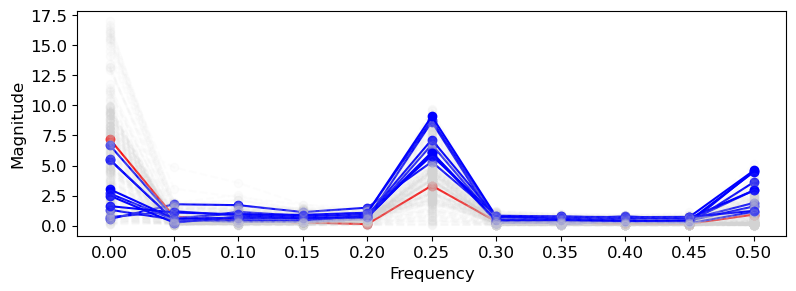

In [15]:
fft(squeezed_lstm_policy, high_z_indices_dur4, low_z_indices_dur4)

explained_variance policy [0.5620184  0.28004256 0.07188928]


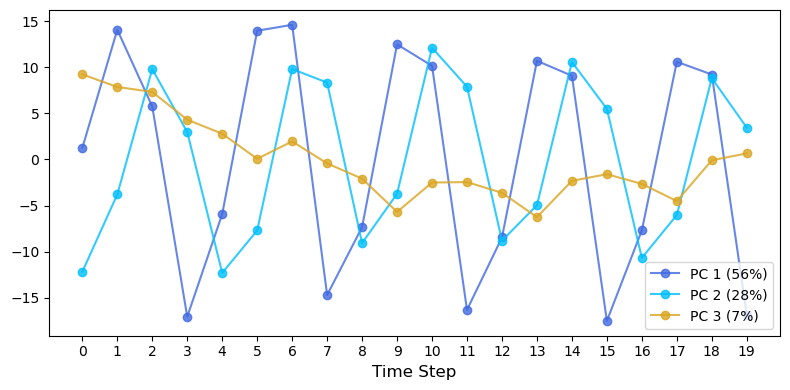

In [93]:
pca_dur4= pca(squeezed_lstm_policy, save_path="pca_dur4")

In [ ]:
# action network analysis

In [29]:
lstm_hidden = np.stack(target4_output_calculator.lstm_hidden)
lstm_hidden = lstm_hidden.squeeze(1).squeeze(1)
lstm_hidden.shape

(20, 256)

In [30]:
lstm_hidden[3, high_z_indices_dur4], lstm_hidden[3, low_z_indices_dur4]

(array([-0.5789463 ,  0.7981214 ,  0.5499212 ,  0.4922107 , -0.7882584 ,
        -0.45930928,  0.62820864, -0.45746386,  0.47447705, -0.7823453 ],
       dtype=float32),
 array([-0.2962554], dtype=float32))

In [32]:
lstm_hidden[7, high_z_indices_dur4], lstm_hidden[7, low_z_indices_dur4]

(array([-0.6311372 ,  0.79954773,  0.59875995,  0.61118186, -0.8069967 ,
        -0.5034373 ,  0.69181305, -0.5697421 ,  0.6069308 , -0.7841474 ],
       dtype=float32),
 array([-0.5930751], dtype=float32))

In [41]:
np.array(target4_output_calculator.actions), np.sum(lstm_hidden[i, high_z_indices_dur4])

(array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]),
 np.float32(0.1415683))

In [43]:
# Predict actions 2 
predicted_actions = []
for i in range(20):
    predicted_actions.append(np.sum(lstm_hidden[i, :])>0.5)

print("Predicted actions:", predicted_actions)

Predicted actions: [np.False_, np.False_, np.False_, np.True_, np.True_, np.False_, np.False_, np.True_, np.True_, np.False_, np.False_, np.True_, np.True_, np.False_, np.False_, np.True_, np.True_, np.False_, np.False_, np.True_]


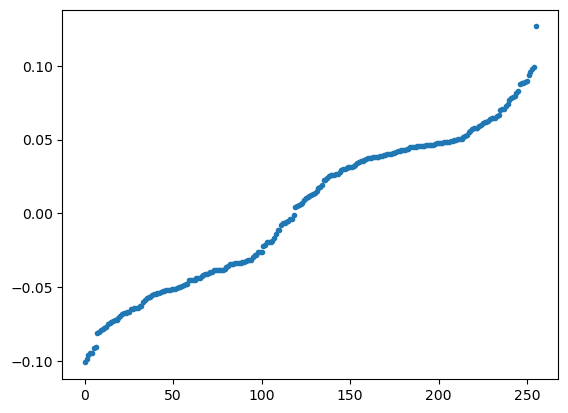

In [18]:
sorted_weights = sorted(model_durt.policy.state_dict()["action_net.weight"][1])
sorted_weights = sorted(model_durt.policy.state_dict()["action_net.weight"][1])
plt.plot(sorted_weights, ".")

In [21]:
model_durt.policy

RecurrentActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=9216, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=9216, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): NatureCNN(
  

In [24]:
reward_list, episode_list =evaluate_policy(model_durt, env_durt,n_eval_episodes=100, deterministic = True, return_episode_rewards=True )
print(np.mean(reward_list))

4.6


In [27]:
# remove neuron with higher weight for action 1
model_modified1 = RecurrentPPO.load(model_path, env=env_durt)
neurons_to_disconnect = []
n_neurons_to_disconnect = 1
for i, n in enumerate(topn_action_weights_dur4[1]):
    neurons_to_disconnect.append(n)
    if i == n_neurons_to_disconnect -1:
        model_modified1.policy.state_dict()["action_net.weight"][1,neurons_to_disconnect] = -0.1
        reward_list, episode_list =evaluate_policy(model_modified1, env_durt,n_eval_episodes=100, deterministic = True, return_episode_rewards=True )
        print(np.mean(reward_list))
        break


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
4.48


In [28]:
# remove neuron with low weight for action 1
model_modified1 = RecurrentPPO.load(model_path, env=env_durt)
neurons_to_disconnect = []
n_neurons_to_disconnect = 1
for i, n in enumerate(topn_action_weights_dur4[0]):
    neurons_to_disconnect.append(n)
    if i == n_neurons_to_disconnect -1:
        model_modified1.policy.state_dict()["action_net.weight"][1,neurons_to_disconnect] = -0.1
        reward_list, episode_list =evaluate_policy(model_modified1, env_durt,n_eval_episodes=100, deterministic = True, return_episode_rewards=True )
        print(np.mean(reward_list))
        break


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
4.64


# duration 2

In [68]:

video_path="videos/V1-0001_City Scene Layout 1 setting0001.mp4"
model_path = 'models/sb3_ppo_1goal_rnn_multistop_multiseq_target2.zip'
target_duration = 2

env_durt = frame_generator.FrameGenerator(video_path, video_path, 24, (124,124),
                                     n_episodes=10, target_duration=target_duration)
model_durt = RecurrentPPO.load(model_path, env=env_durt)


wrapped_model_durt = sb3Wrapper(model_durt)

target2_output_calculator, high_z_indices_dur2, low_z_indices_dur2, topn_action_weights_dur2 = get_info_for_neural_oscillation(wrapped_model_durt, model_durt, env_durt,video_path=video_path, model_path=model_path, target_duration=target_duration, threshold=2)
# _, high_z_indices_dur2, low_z_indices_dur2, topn_action_weights_dur2 = get_info_for_neural_oscillation(video_path=video_path, model_path=model_path, target_duration=target_duration, process_layer_output=False, threshold=1.5)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
target time 2
current_frame_index 0
action 0
reward 0
current_frame_index 1
action 1
reward 1
current_frame_index 2
action 0
reward 0
current_frame_index 3
action 1
reward 1
current_frame_index 4
action 0
reward 0
current_frame_index 5
action 1
reward 1
current_frame_index 6
action 0
reward 0
current_frame_index 7
action 1
reward 1
current_frame_index 8
action 0
reward 0
current_frame_index 9
action 1
reward 1
total rewards 5


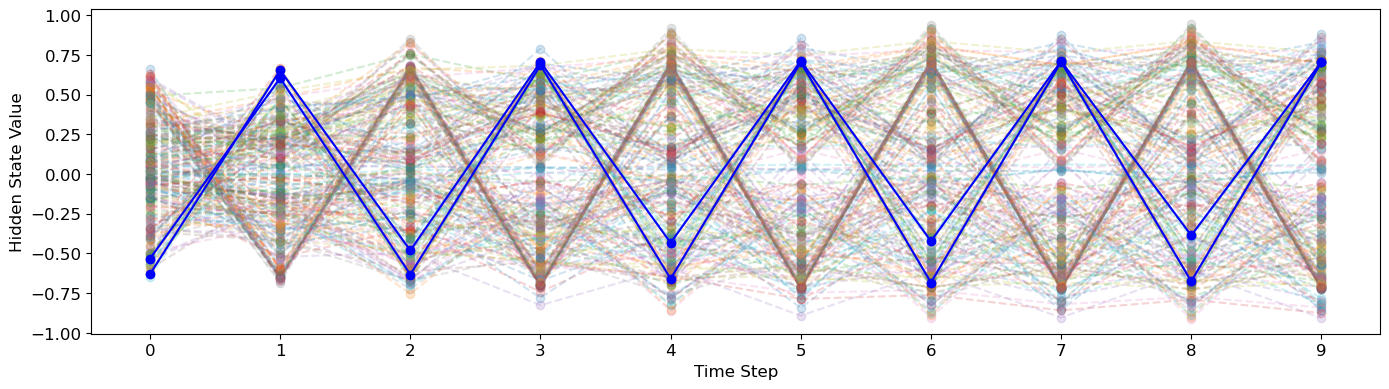

In [75]:
plot_hidden_state(target2_output_calculator.lstm_hidden, target2_output_calculator.lstm_cell, high_z_indices_dur2, low_z_indices_dur2, topn_action_weights_dur2[0], save_path="raw_activations_dur2")

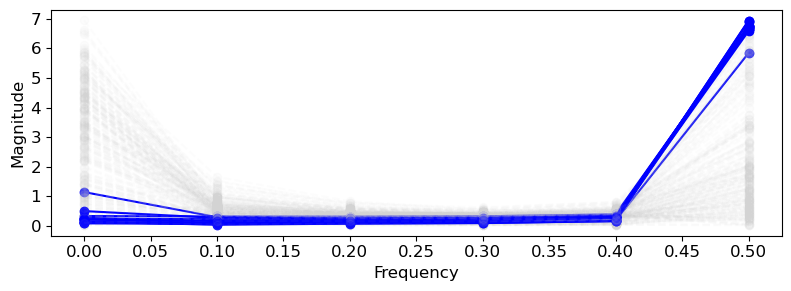

In [73]:
squeezed_lstm_policy = np.array(target2_output_calculator.lstm_hidden).squeeze(1).squeeze(1)
squeezed_lstm_value = np.array(target2_output_calculator.lstm_cell).squeeze(1).squeeze(1)
fft(squeezed_lstm_policy, high_z_indices_dur2, low_z_indices_dur2, save_path="fft_dur2")

explained_variance policy [0.71365196 0.25716323 0.02211719]


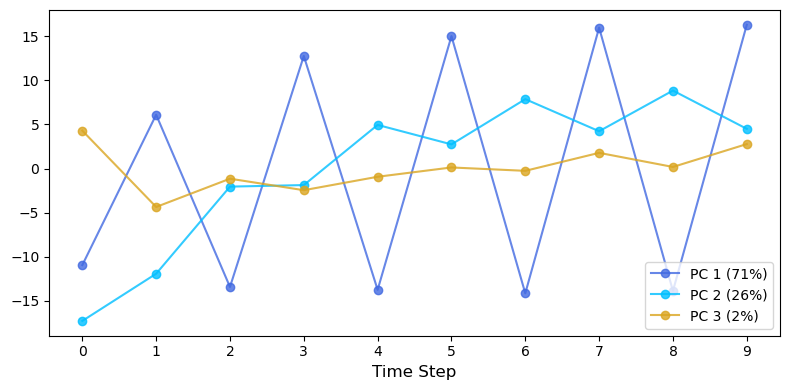

In [71]:
pca_dur2= pca(squeezed_lstm_policy, save_path="pca_duration2.png", pca_components=3, )

# duration 5

In [79]:

video_path="videos/V1-0001_City Scene Layout 1 setting0001.mp4"
model_path = 'models/sb3_ppo_1goal_rnn_multistop_multiseq_target5.zip'
target_duration = 5

env_durt = frame_generator.FrameGenerator(video_path, video_path, 24, (124,124),
                                     n_episodes=10, target_duration=target_duration)
model_durt = RecurrentPPO.load(model_path, env=env_durt)


wrapped_model_durt = sb3Wrapper(model_durt)

target5_output_calculator, high_z_indices_dur5, low_z_indices_dur5, topn_action_weights_dur5 = get_info_for_neural_oscillation(wrapped_model_durt, model_durt, env_durt, video_path=video_path, model_path=model_path, target_duration=target_duration,threshold=2.5 )
# _, high_z_indices_dur5, low_z_indices_dur5, topn_action_weights_dur5 = get_info_for_neural_oscillation(wrapped_model_durt, model_durt, env_durt, video_path=video_path, model_path=model_path, target_duration=target_duration, process_layer_output=False, threshold=2.5)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
target time 5
current_frame_index 0
action 0
reward 0
current_frame_index 1
action 0
reward 0
current_frame_index 2
action 0
reward 0
current_frame_index 3
action 1
reward -1
current_frame_index 4
action 1
reward 1
current_frame_index 5
action 0
reward 0
current_frame_index 6
action 0
reward 0
current_frame_index 7
action 0
reward 0
current_frame_index 8
action 0
reward 0
current_frame_index 9
action 1
reward 1
current_frame_index 10
action 0
reward 0
current_frame_index 11
action 0
reward 0
current_frame_index 12
action 0
reward 0
current_frame_index 13
action 0
reward 0
current_frame_index 14
action 1
reward 1
current_frame_index 15
action 0
reward 0
current_frame_index 16
action 0
reward 0
current_frame_index 17
action 0
reward 0
current_frame_index 18
action 0
reward 0
current_frame_index 19
action 1
reward 1
current_frame_index 20
action 0
reward 0
current_frame_in

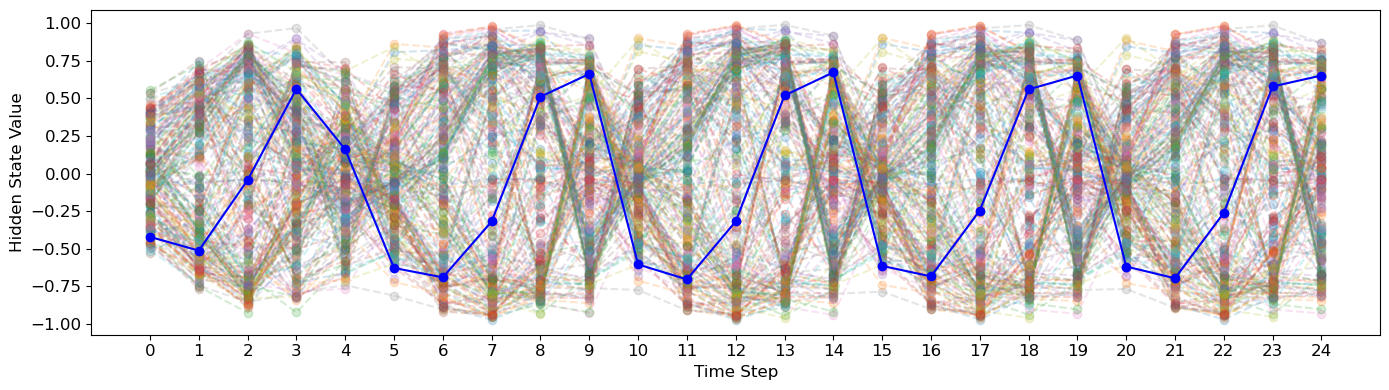

In [80]:
plot_hidden_state(target5_output_calculator.lstm_hidden, target5_output_calculator.lstm_cell, high_z_indices_dur5, low_z_indices_dur5, topn_action_weights_dur5[0], save_path="raw_activations_dur5")

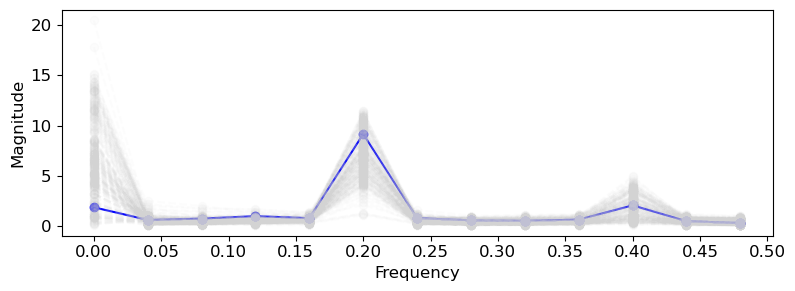

In [81]:
squeezed_lstm_policy = np.array(target5_output_calculator.lstm_hidden).squeeze(1).squeeze(1)
squeezed_lstm_value = np.array(target5_output_calculator.lstm_cell).squeeze(1).squeeze(1)
fft(squeezed_lstm_policy, high_z_indices_dur5, low_z_indices_dur5, save_path="fft_dur5")

explained_variance policy [0.56254435 0.3531815  0.04474331]


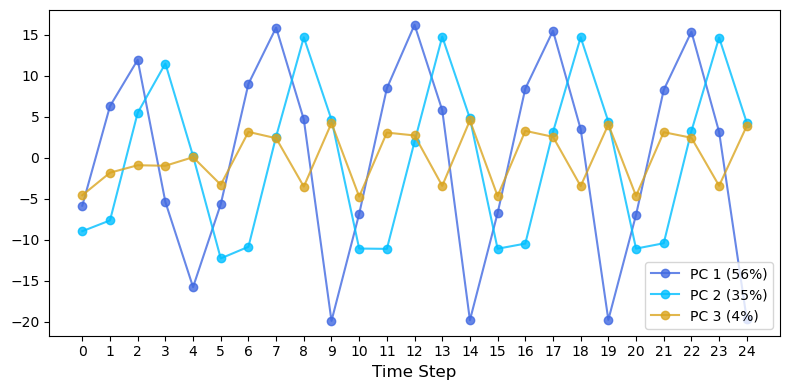

In [82]:
pca_dur5= pca(squeezed_lstm_policy, pca_components=3, save_path="pca_dur5")

# target = 3

In [84]:
# duration = 3
video_path="videos/V1-0001_City Scene Layout 1 setting0001.mp4"
model_path = 'models/sb3_ppo_1goal_rnn_multistop_multiseq_target3.zip'
target_duration = 3


env_durt = frame_generator.FrameGenerator(video_path, video_path, 24, (124,124),
                                     n_episodes=10, target_duration=target_duration)
model_durt = RecurrentPPO.load(model_path, env=env_durt)


wrapped_model_durt = sb3Wrapper(model_durt)

target3_output_calculator, high_z_indices_dur3, low_z_indices_dur3, topn_action_weights_dur3 = get_info_for_neural_oscillation(wrapped_model_durt, model_durt, env_durt, video_path=video_path, model_path=model_path, target_duration=target_duration, threshold=2)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
target time 3
current_frame_index 0
action 0
reward 0
current_frame_index 1
action 0
reward 0
current_frame_index 2
action 1
reward 1
current_frame_index 3
action 0
reward 0
current_frame_index 4
action 0
reward 0
current_frame_index 5
action 1
reward 1
current_frame_index 6
action 0
reward 0
current_frame_index 7
action 0
reward 0
current_frame_index 8
action 1
reward 1
current_frame_index 9
action 0
reward 0
current_frame_index 10
action 0
reward 0
current_frame_index 11
action 1
reward 1
current_frame_index 12
action 0
reward 0
current_frame_index 13
action 0
reward 0
current_frame_index 14
action 1
reward 1
total rewards 5


In [9]:
reward_list, episode_list =evaluate_policy(model_durt, env_durt,n_eval_episodes=100, deterministic = True, return_episode_rewards=True )
sum(reward_list)

np.float64(500.0)

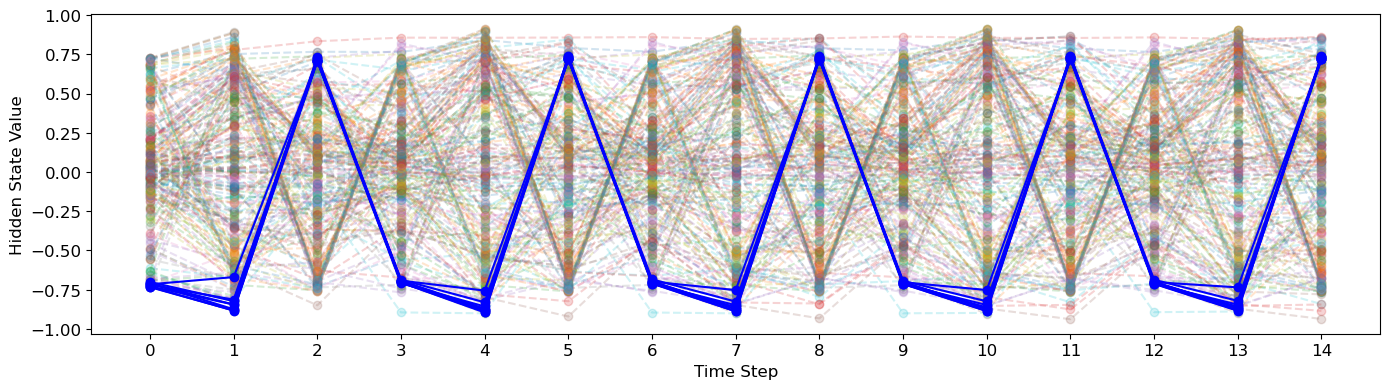

In [85]:
plot_hidden_state(target3_output_calculator.lstm_hidden, target3_output_calculator.lstm_cell, high_z_indices_dur3, low_z_indices_dur3, topn_action_weights_dur3[0], save_path="raw_activations_dur3")

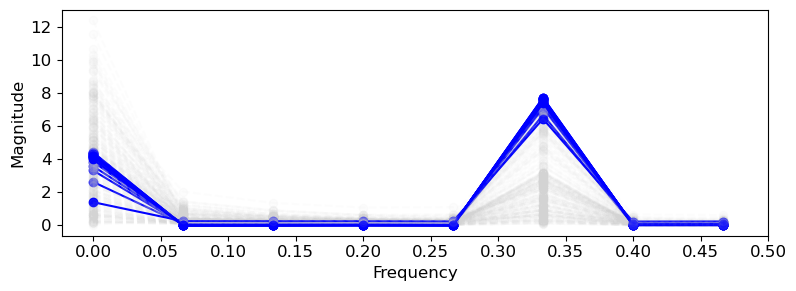

In [86]:
squeezed_lstm_policy = np.array(target3_output_calculator.lstm_hidden).squeeze(1).squeeze(1)
squeezed_lstm_value = np.array(target3_output_calculator.lstm_cell).squeeze(1).squeeze(1)
fft(squeezed_lstm_policy, high_z_indices_dur3, low_z_indices_dur3, save_path="fft_dur3")

explained_variance policy [0.476804   0.39107963 0.11064821]


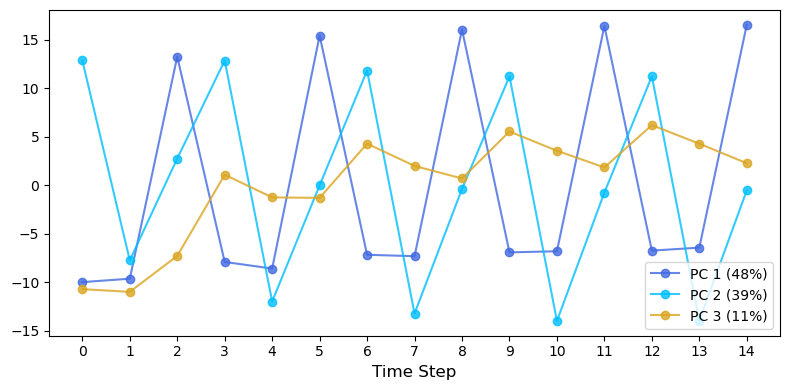

In [87]:
pca_dur3= pca(squeezed_lstm_policy, pca_components=3, save_path="pca_dur3")

# random video duration 4

In [6]:
# duration = 4
video_path="videos/V1-0001_City Scene Layout 1 setting0001.mp4"
model_path = 'models/sb3_ppo_1goal_rnn_multistop_multiseq_randomvideo.zip'
target_duration = 4


env_durt = frame_generator.FrameGenerator(video_path, video_path, 24, (124,124),
                                     n_episodes=10, target_duration=target_duration)
model_durt = RecurrentPPO.load(model_path, env=env_durt)


wrapped_model_durt = sb3Wrapper(model_durt)

targetrandom_output_calculator, high_z_indices_random, low_z_indices_random, topn_action_weights_random = get_info_for_neural_oscillation(wrapped_model_durt, model_durt, env_durt, video_path=video_path, model_path=model_path, target_duration=target_duration, threshold=1.5)

C:\Users\Administrator\miniconda3\envs\overcooked_gpulab\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
C:\Users\Administrator\miniconda3\envs\overcooked_gpulab\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
target time 4
current_frame_index 0
action 0
reward 0
current_frame_index 1
action 0
reward 0
current_frame_index 2
action 0
reward 0
current_frame_index 3
action 0
reward -1
current_frame_index 4
action 0
reward 0
current_frame_index 5
action 0
reward 0
current_frame_index 6
action 0
reward 0
current_frame_index 7
action 0
reward -1
current_frame_index 8
action 0
reward 0
current_frame_index 9
action 0
reward 0
current_frame_index 10
action 0
reward 0
current_frame_index 11
action 0
reward -1
current_frame_index 12
action 0
reward 0
current_frame_index 13
action 0
reward 0
current_frame_index 14
action 0
reward 0
current_frame_index 15
action 0
reward -1
current_frame_index 16
action 0
reward 0
current_frame_index 17
action 0
reward 0
current_frame_index 18
action 0
reward 0
current_frame_index 19
action 0
reward -1
total rewards -5


In [7]:
reward_list, episode_list =evaluate_policy(model_durt, env_durt,n_eval_episodes=100, deterministic = True, return_episode_rewards=True )
sum(reward_list)

C:\Users\Administrator\miniconda3\envs\overcooked_gpulab\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


np.float64(-500.0)